In [9]:
import numpy as np
import matplotlib.pyplot as plt
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)


In [10]:
def kmeans(X, k):
 
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
 
    return clusters, stds

In [17]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
 
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
            # use a fixed std 
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)

        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b

                loss = (y[i] - F).flatten() ** 2
             #   print('Loss: {0:.2f}'.format(loss[0]))

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            print(a)
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

[1.72870227e-04 4.42938405e-01]
[2.07446037e-04 4.75759290e-01]
[2.88718403e-04 5.38031500e-01]
[3.26660598e-04 5.62051083e-01]
[3.65949594e-04 5.84432413e-01]
[3.66474906e-04 5.84716619e-01]
[3.78091781e-04 5.90908158e-01]
[4.35716281e-04 6.19229865e-01]
[4.60738926e-04 6.30441144e-01]
[6.00962455e-04 6.83977032e-01]
[6.28410826e-04 6.92965725e-01]
[6.86408394e-04 7.10683803e-01]
[0.00075534 0.72977927]
[0.00076695 0.73281007]
[0.00087439 0.75864824]
[0.00093786 0.77227784]
[0.00099204 0.78309169]
[0.0010233  0.78901773]
[0.00143462 0.85080109]
[0.00149111 0.85747154]
[0.00199447 0.90433179]
[0.00236721 0.92863812]
[0.00349831 0.97248539]
[0.00537282 0.99776154]
[0.00620469 0.99996294]
[0.00783316 0.99616866]
[0.0078706  0.99599277]
[0.00968963 0.98437406]
[0.0121537  0.96276047]
[0.01703409 0.91312257]
[0.018091   0.90211873]
[0.02013372 0.88100934]
[0.03171147 0.77089193]
[0.04041892 0.70050461]
[0.04355881 0.67752016]
[0.06527188 0.54615304]
[0.08947052 0.44028645]
[0.10839324 0.37

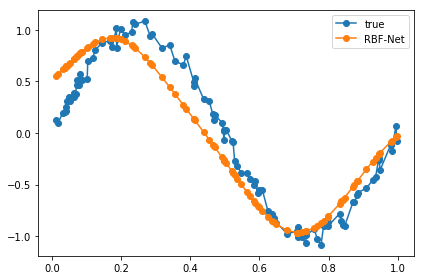

In [18]:
# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise
 
rbfnet = RBFNet(lr=1e-2, k=2)
rbfnet.fit(X, y)
 
y_pred = rbfnet.predict(X)
 
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
 
plt.tight_layout()
plt.show()